# Expérimentation sur les tests d'indépendance de Fisher exact et le $\chi^2$.

Plan de la séance:

- Programmation du formalisme des probabilités
- Simulation pour les fréquences de table de contingence produites par deux variables indépendantes ou non. 
- Énumération et graphes des tables de contingences de même marginales sous l'hypothèse de Fisher
- Vérification expérimentale de la formule de Fisher (et une façon de la re-découvrir)
- Calcul de la $p$-value pour le test de Fisher exact
- Vérification expérimentale de l'approximation par les lois $\chi^2$ du test de Fisher
- Application du test de $\chi^2$ sur des tables plus grandes.

## 1. Programmation du formalisme des probabilités

Nous allons travailler avec $\Omega := \Omega(N)$ qui est la loi uniforme sur les entiers de $0$ à $N-1$, chacun évenement $\omega \in \Omega$ ayant une probabilité $P(\omega) := \frac{1}{N}$.

Nos variables aléatoires seront des fonctions déterministes définient par trois entiers $(a,b,c)$:
$$X_{a,b,c}(\omega) := (a\omega + b)\mod c.$$

TODO 1.1: Complétez la fonction __create_random_outcome_generator__ qui simule des tirages aléatoire selon l'espace probabilisé $\Omega$. Complétez la fonction __create_outcome_probability__ qui crée une fonction donnant la probabilité d'un évenement $\omega$. Vérifiez si la somme probabilité fait bien $1$. Corrigez le problème en important le module __fractions__ documenté ici: https://docs.python.org/3/library/fractions.html . Compléter la fonction __create_iterator_on_outcomes__ qui un itérateur sur les évènements possibles.

In [15]:
from typing import *
import random
import fractions #TODO


def create_random_outcome_generator(N:int)->Callable[[],int]:
    return lambda : random.randint(0,N-1)

def create_outcome_probability(N:int)->Callable[[],float]:
    return lambda w: {True: float(fractions.Fraction(1/N)), False: 0}[0 <= w < N]

def create_iterator_on_outcomes(N:int)->range:
    return range(N)

N = 20
generate_outcome = create_random_outcome_generator(N)
print(f'some events {[generate_outcome() for _ in range(10)]}')

outcome_probability = create_outcome_probability(N)
some_outcome_probabilities = [ outcome_probability(omega) for omega in range(-4,N+4)]
print(f'some outcome probabilities {some_outcome_probabilities}')


outcomes_iterator = create_iterator_on_outcomes(N)
print(f'Omega = {[omega for omega in outcomes_iterator]}')

total_probabilities = sum(outcome_probability(omega) for omega in outcomes_iterator)
print(f'total_probabilities {total_probabilities}')

    

some events [14, 8, 2, 12, 2, 0, 13, 0, 14, 5]
some outcome probabilities [0, 0, 0, 0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0, 0, 0, 0]
Omega = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
total_probabilities 1.0000000000000002


In [16]:
type(range(10))

range

TODO 1.2: Complètez la fonction __create_random_variable(a,b,c)__ qui retourne la variable aléatoire paramétrée par $a$, $b$ et $c$. A partir de cette fonction créer trois variables aléatoires $X$, $Y$ et $Z$ telle que $X$ et $Y$ soient indépendentes alors que $X$ et $Z$ ne le soient pas.   

In [17]:
def create_random_variable(a:int,b:int,c:int)->Callable[[int],int]:
    return lambda omega : (a*omega+b)%c # TODO

X = create_random_variable(1,0,4)
Y = create_random_variable(1,0,5)
Z = create_random_variable(1,0,2)

TODO 1.3: Calculez une liste de 13 réalisations de la variable aléatoire $X$ (sur l'espace de probabilité $\Omega$). Faites de même sur $Y$ et $Z$.

In [18]:
sample_X = [ X(generate_outcome()) for _ in range(13)]
print(f'sample_X {sample_X}')
sample_Y = [ Y(generate_outcome()) for _ in range(13)]
print(f'sample_Y {sample_Y}')
sample_Z = [ Z(generate_outcome()) for _ in range(13)]
print(f'sample_Z {sample_Z}')

sample_X [3, 2, 2, 3, 0, 1, 3, 3, 0, 2, 0, 1, 2]
sample_Y [2, 4, 4, 1, 4, 3, 4, 2, 2, 2, 2, 3, 3]
sample_Z [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]


TODO 1.4: Completez dans __get_distribution__ le calcul de la loi d'une variable aléatoire (discrète et à support fini) sous la forme d'un dictionnaire où seul les élements de probabilité non-nulle sont présents.

In [19]:
def get_distribution(X:Callable[[int],int],\
                 outcomes_iterator:range, outcome_probability:Callable[[int],fractions.Fraction])->Dict:
    distribution = {}
    for omega in outcomes_iterator:
        x = X(omega)
        if x not in distribution:
            distribution[x]=0
        distribution[x] += outcome_probability(omega)
    return {x: distribution[x] for x in distribution if distribution[x] > 0}
    

In [20]:
X_distribution = get_distribution(X,outcomes_iterator,outcome_probability)
print(f'X_distribution {X_distribution}')
Y_distribution = get_distribution(Y,outcomes_iterator,outcome_probability)
print(f'Y_distribution {Y_distribution}')
Z_distribution = get_distribution(Z,outcomes_iterator,outcome_probability)
print(f'Z_distribution {Z_distribution}')

X_distribution {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
Y_distribution {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
Z_distribution {0: 0.49999999999999994, 1: 0.49999999999999994}


TODO 1.5: En prenant soin d'utiliser une fonction anonyme (__lambda omega: ... __) calculez une liste de 7 réalisations de la paire de variables aléatoire $(X,Z)$.

In [21]:
sample_XZ = [ (lambda omega: (X(omega),Z(omega)))(generate_outcome()) for _ in range(7)] # TODO
print(f'sample_XZ {sample_XZ}')

sample_XZ [(1, 1), (3, 1), (0, 0), (3, 1), (1, 1), (1, 1), (3, 1)]


TODO 1.6: Complétez la fonction __joint_variables__ qui étant donné une liste de variable aléatoires renvoit le vecteur/tuple de leur réalisation sur le même évènement $\omega$. Avec cette fonction calculez la variable aléatoire $XY(\omega) := (X(\omega),Y(\omega))$. 

In [22]:
def joint_variables(Xs:List[Callable[[int],int]])->Callable[[int],Tuple[int]]:
    return lambda omega: tuple([ X(omega) for X in Xs]) # TODO

XY = joint_variables([X,Y])

TODO 1.7: En ignorant les possibles problèmes de typage, calculez la loi jointe de $X$ et $Y$ avec la fonction __get_distribution__. Que pensez vous du typage en python ?

In [23]:
XY_distribution = get_distribution(XY,outcomes_iterator,outcome_probability)
print(f'XY_distribution {XY_distribution}')

XY_distribution {(0, 0): 0.05, (1, 1): 0.05, (2, 2): 0.05, (3, 3): 0.05, (0, 4): 0.05, (1, 0): 0.05, (2, 1): 0.05, (3, 2): 0.05, (0, 3): 0.05, (1, 4): 0.05, (2, 0): 0.05, (3, 1): 0.05, (0, 2): 0.05, (1, 3): 0.05, (2, 4): 0.05, (3, 0): 0.05, (0, 1): 0.05, (1, 2): 0.05, (2, 3): 0.05, (3, 4): 0.05}


TODO 1.8: Complétez la fonction __get_marginal_distribution__ calculant la loi marginal $X_i$ étant donné une loi jointe pour $(X_j)_{j=0,\ldots k-1}$. Puis calculer les marginals des lois jointes $(X,Y)$ et $(X,Z)$. 

In [24]:
def get_marginal_distribution(Xs_distribution:Dict,index:int)->Dict:
    marginal_distribution = {}
    for p in Xs_distribution:
        if p[index] not in marginal_distribution:
            marginal_distribution[p[index]] = 0
        marginal_distribution[p[index]] += Xs_distribution[p]
    return marginal_distribution

In [25]:
print(f'XY_distribution {XY_distribution}')
X_marginal_from_XY = get_marginal_distribution(XY_distribution,0)
Y_marginal_from_XY = get_marginal_distribution(XY_distribution,1)
print(f'X_marginal_from_XY{X_marginal_from_XY}')

XY_distribution {(0, 0): 0.05, (1, 1): 0.05, (2, 2): 0.05, (3, 3): 0.05, (0, 4): 0.05, (1, 0): 0.05, (2, 1): 0.05, (3, 2): 0.05, (0, 3): 0.05, (1, 4): 0.05, (2, 0): 0.05, (3, 1): 0.05, (0, 2): 0.05, (1, 3): 0.05, (2, 4): 0.05, (3, 0): 0.05, (0, 1): 0.05, (1, 2): 0.05, (2, 3): 0.05, (3, 4): 0.05}
X_marginal_from_XY{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


TODO 1.9: Complétez la fonction __get_joint_distribution_of_two_variables_assuming_independance__ calculant la loi jointe de deux variables _supposées indépendantes_. Vous utiliserez $\Omega^2 := \Omega \times \Omega$ au lieu de $\Omega$ comme espace de probabilité pour définir une nouvelle variable aléatoire retournant une paire d'entiers.

In [26]:
import itertools

def get_joint_distribution_of_two_variables_assuming_independance(Xs:List[Callable[[int],int]],\
            outcomes_iterator:range,outcome_probability:Callable[[int],fractions.Fraction])->Dict:
    distribution = {}
    X_marginal = get_distribution(Xs[0],outcomes_iterator,outcome_probability)
    Y_marginal = get_distribution(Xs[1],outcomes_iterator,outcome_probability)
    for x in X_marginal:
        for y in Y_marginal:
                distribution[(x,y)] = X_marginal[x]*Y_marginal[y]
    return distribution


In [27]:
new_XY_distribution = get_joint_distribution_of_two_variables_assuming_independance([X,Y],\
                                    outcomes_iterator,outcome_probability)
print(f'new_XY_distribution {new_XY_distribution}')

new_XY_distribution {(0, 0): 0.05, (0, 1): 0.05, (0, 2): 0.05, (0, 3): 0.05, (0, 4): 0.05, (1, 0): 0.05, (1, 1): 0.05, (1, 2): 0.05, (1, 3): 0.05, (1, 4): 0.05, (2, 0): 0.05, (2, 1): 0.05, (2, 2): 0.05, (2, 3): 0.05, (2, 4): 0.05, (3, 0): 0.05, (3, 1): 0.05, (3, 2): 0.05, (3, 3): 0.05, (3, 4): 0.05}


TODO 1.10: Généralisez le cas de $n\geq 2$ variables dans la fonction __get_joint_distribution_of_variables_assuming_independance__ en passant par l'espace de probabilité $\Omega^n$ et la fonction __reduce__ du module __functools__ documentée ici https://docs.python.org/3/library/functools.html#functools.reduce. Utilisez cette nouvelle fonction que vous avez définie pour calculer la loi jointe $(X,Y,Z)$ _en supposant l'indépendance_ des trois variables. 

In [53]:
import operator
import functools

def get_joint_distribution_of_variables_assuming_independance(Xs:List[Callable[[int],int]],\
            outcomes_iterator:range,outcome_probability:Callable[[int],fractions.Fraction])->Dict:
            pass


In [55]:
new_XYZ_distribution_assuming_independance = get_joint_distribution_of_variables_assuming_independance([X,Y,Z],\
            outcomes_iterator,outcome_probability)
print(f'new_XYZ_distribution_assuming_independance {new_XYZ_distribution_assuming_independance}')

new_XYZ_distribution_assuming_independance None


TODO 1.11: Complétez la fonction __are_variables_independant__ qui détermine si les variables données sur l'espace de probabilité commun $\Omega$ sont indépendantes. Testez cette fonction avec les lois jointes $(X,Y)$, $(X,Z)$ et $(X,Y,Z)$.

In [56]:
def are_variables_independant(Xs:List[Callable[[int],int]],\
            outcomes_iterator:range,outcome_probability:Callable[[int],fractions.Fraction])->bool:
            assert(len(Xs))
            real_XY_distribution = get_distribution(joint_variables(Xs),outcomes_iterator,outcome_probability)
            XY_distribution_assuming_independance = get_joint_distribution_of_two_variables_assuming_independance(Xs,outcomes_iterator,outcome_probability)

            for (x,y) in real_XY_distribution:
                if real_XY_distribution[x,y] != XY_distribution_assuming_independance[x,y]:
                    return False
            return True


In [58]:
print(f'independance of X and Y : {are_variables_independant([X,Y],outcomes_iterator,outcome_probability)}')
print(f'independance of X and Z : {are_variables_independant([X,Z],outcomes_iterator,outcome_probability)}')
# print(f'independance of X, Y and Z : {are_variables_independant([X,Y,Z],outcomes_iterator,outcome_probability)}')

independance of X and Y : True
independance of X and Z : False


TODO 1.12: (Optionnel) Étudiez empiriquement les conditions sur les triplets $(a,b,d)$ et $(e,f,g)$ pour l'indépendance de $X_{a,b,c}$ et $X_{e,f,g}$ définie sur un espace de probabilité ("uniforme") des $N$ entiers $\{0,\ldots, N-1\}$. Pouvez vous prouver certaines de vos conjectures ?

## 2. Tableaux de contingence

Soit $X$ une variable aléatoire à valeur dans $\{0,\ldots n-1\}$ par exemple $X_{a,b,n}$ et $Y$ une variable aléatoire à valeur dans $\{0,\ldots m-1\}$, par exemple $X_{c,d,m}$.

A partir de la variable jointe $(X,Y)$ et de $k$ réalisations nous allons construire son __tableau de contingence__ qui est une matrice $T:= (T_{i,j})_{i=0,\ldots n, j=0,\ldots m}$ où:
- pour $i < n$ et $j < m$, $T_{i,j}$ est le nombre de réalisations/tirages de $(X(\omega)=i,Y(\omega)=j)$.
- pour $i < n$ et $j = m$, $T_{i,m} := \sum_{j=0}^{m-1} T_{i,j}$ la somme partielle sur la colonne $i$.
- pour $i = n$ et $j = n$, $T_{n,j} := \sum_{i=0}^{n-1} T_{i,j}$ la somme partielle sur la ligne $j$.
- $T_{n,m} = K = \sum_{i<n,j<m} T_{i,j}$ le nombre de tirages.

### 2.1 Simulation de la collecte de données

Oublions un instant la construction des variables aléatoires de la partie précédente et construisons un générateur pour deux variables jointes $(X,Y)$ dont nous précisons la valeur maximale pour chaque variable ici $1$ pour les deux.

In [34]:
def XY():
    p = {(0,0): 0.4, (0,1):0.2, (1,0):0.3, (1,1):0.1}
    r = random.random()
    for xy in p:
        if p[xy] >= r:
            return xy
        r -= p[xy]
    assert(False)
    
maxX = 1
maxY = 1

Remarquez qu'il est possible d'obtenir le même résultat:

In [35]:
def XY_from_omega(omega:int):
    if 0 <= omega < 8:
        return (0,0)
    elif omega < 12:
        return (0,1)
    elif omega < 18:
        return (1,0)
    elif omega < 20:
        return (1,1)
    assert(False)
    
def alt_XY():
    global generate_outcome
    return XY_from_omega(generate_outcome)

TODO 2.1: Complétez la fonction __simulate_X_and_Y_for_tableau__, remplissez un tableau après 9 tirages selon __XY__ et afficher le avec __print_tableau__.

In [36]:
def build_tableau_from_data(xys:List[Tuple[int]],maxX:int,maxY:int):
    tableau = {(x,y):0 for x in range(maxX + 2) for y in range(maxY+2)}
    for (x,y) in xys:
        for(xx,yy) in [(x,y),(x,maxY+1),(maxX+1,y),(maxX+1,maxY+1)]:
            tableau[(xx,yy)] += 1
    return tableau


def simulate_X_and_Y_for_tableau(XY:Callable[[],Tuple[int]],maxX:int,maxY:int,nb_tosses:int)-> Dict:
    xys = [XY() for _ in range(nb_tosses)]
    return build_tableau_from_data(xys,maxX,maxY)


def print_tableau(tableau:Dict)->None:
    (xs,ys) = ([ x for (x,_) in tableau],[ y for (y,_) in tableau])
    (maxX,maxY) = (max(xs),max(ys))
    print('<tableau>')
    for y in range(maxY+1):
        row = ''
        for x in range(maxX+1):
            if tableau[(x,y)] < 10: # XXX
                row += f'[ {tableau[(x,y)]}]'
            else:
                row += f'[{tableau[(x,y)]}]'
        print(row)
    print('</tableau>')
        
    

In [37]:
nb_tosses = 6

tableau = simulate_X_and_Y_for_tableau(XY,maxX,maxY,nb_tosses)

print_tableau(tableau)

<tableau>
[ 3][ 1][ 4]
[ 2][ 0][ 2]
[ 5][ 1][ 6]
</tableau>


### 2.2 Enumération et $p$-value pour le test de Fisher sur des tableaux $2 \times 2$.


Nous représentons les tableaux de contingence par des dictionnaires.
Pour l'instant nous supposons que $n=2=m$.

TODO 2.2 : Etant donné un tableau de contingence lister les tableaux qui ont les même marginables empiriques qu'un tableau donné dans la fonction __list_all_2x2_tableaux_with_same_marginals__.

In [38]:
import copy

def list_all_2x2_tableaux_with_same_marginals(tableau:Dict):
    tableaux = [copy.deepcopy(tableau)]
    while min([tableaux[0][(0,0)],tableaux[0][(1,1)]]) > 0:
        new_tableau = copy.deepcopy(tableaux[0])
        new_tableau[(0,0)] -= 1
        new_tableau[(1,1)] -= 1
        new_tableau[(1,0)] += 1
        new_tableau[(0,1)] += 1
        tableaux.insert(0,new_tableau)
    while min([tableaux[-1][(1,0)],tableaux[-1][(0,1)]]) > 0:
        new_tableau = copy.deepcopy(tableaux[-1])
        new_tableau[(0,0)] += 1
        new_tableau[(1,1)] += 1
        new_tableau[(1,0)] -= 1
        new_tableau[(0,1)] -= 1
        tableaux += [new_tableau]
    return tableaux

In [39]:
all_tableaux = list_all_2x2_tableaux_with_same_marginals(tableau)
for t in all_tableaux:
    print_tableau(t)

<tableau>
[ 3][ 1][ 4]
[ 2][ 0][ 2]
[ 5][ 1][ 6]
</tableau>
<tableau>
[ 4][ 0][ 4]
[ 1][ 1][ 2]
[ 5][ 1][ 6]
</tableau>


TODO 2.3: Compléter la fonction qui sous hypothèse que les marginales soient conservé et que les deux variables soient indépendante retire les paires $(x,y)$. (Explications complémentaires au tableau sur pourquoi cela se réduit à l'exploration d'une permutation et pas d'une paire de permutations)

In [60]:
def hash_tableau(tableau:Dict)->Tuple[Tuple[int]]:
    n = max([x for (x,_) in tableau])
    m = max([y for (_,y) in tableau])
    return tuple([ tuple([ tableau[x,y] for x in range(n+1)]) for y in range(m+1)])

def dehash_tableau(hashed_tableau:Tuple[Tuple[int]]):
    n = len(hashed_tableau[0])
    m = len(hashed_tableau)
    return { (x,y): hashed_tableau[y][x] for x in range(n) for y in range(m)}
    
def canonical_box_of_balls_from_distribution(distribution):
    balls = []
    for z in range(len(distribution)):
        balls += distribution[z]*[z]
    return balls
    
def all_resamplings_of_tableau(tableau:Dict)->Dict:
    n = max([x for (x,_) in tableau])
    m = max([y for (_,y) in tableau])
    k = tableau[n,m]
    X_marginal_distribution = tuple([tableau[x,m] for x in range(n)])
    X_box_of_balls = canonical_box_of_balls_from_distribution(X_marginal_distribution)
    Y_marginal_distribution = tuple([tableau[n,y] for y in range(m)])
    Y_box_of_balls = canonical_box_of_balls_from_distribution(Y_marginal_distribution)
    permutations_per_tableau = {}
    for a_ball_permutation in itertools.permutations(range(k)):
        xys = [(X_box_of_balls[i],Y_box_of_balls[a_ball_permutation[i]]) for i in range(k)]
        its_tableau = build_tableau_from_data(xys,n-1,m-1)
        its_hashed_tableau = hash_tableau(its_tableau)
        if (its_hashed_tableau not in permutations_per_tableau):
            print_tableau(its_tableau)
            permutations_per_tableau[its_hashed_tableau] = []
        permutations_per_tableau[its_hashed_tableau] += [a_ball_permutation]
        return permutations_per_tableau
        

In [62]:
permutations_per_tableau = all_resamplings_of_tableau(tableau)
for t in permutations_per_tableau:
    print_tableau(dehash_tableau(t))
    print(f'nb permutation {len(permutations_per_tableau[t])}')

<tableau>
[ 4][ 0][ 4]
[ 1][ 1][ 2]
[ 5][ 1][ 6]
</tableau>
<tableau>
[ 4][ 0][ 4]
[ 1][ 1][ 2]
[ 5][ 1][ 6]
</tableau>
nb permutation 1


TODO 2.4: Notez la preuve au tableau de la formule de Fisher pour les tableau $2 \times 2$ et $3 \times 3$.

Soit deux variables X et Y admettant deux états S1 et S2 différents chacune:

    |  X    |Y      |total  |
    |-------|-------|-------|
    |n      |m      |  m+n  |
    |-------|-------|-------|
    |p      |q      |  p+q  |
    |-------|-------|-------|
    |n+p    |m+q    |n+m+p+q|

    Si X et Y sont indépendant alors la probabilité d'avoir P(X=m,Y=n) = P(X=m).P(Y=n) -> On peut calculer la probabilité de chaque cas pour X et Y pour calculer la probabilité d'observer le tableau de contingence donné.
    On calcule pour tout tableau de contingence la probabilité de l'observer.
    p-value = somme des probabilités associés à chaque tableau au moins aussi probable que le tableau étudié.

la probabilité de la configuration: $P = \frac{(m+n)!(p+q)!(n+p)!(m+q)!}{n!m!p!q!}$


TODO 2.5: Pour un tableau, compléter le calcul de sa probabilité sous l'hypothèse de Fisher pour le test d'indépendance.

In [63]:
import math

def probability_of_a_tableau(tableau:Dict)->fractions.Fraction:
    n = max([x for (x, _) in tableau])
    m = max([y for (_, y) in tableau])
    p = 1
    for (x, y) in tableau :
        if (x < n and y < m) or (x == n and y == m) :
            p /= math.factorial(tableau[(x, y)])
        else :
            p *= math.factorial(tableau[(x, y)])
    return p

In [64]:
for t in all_tableaux:
    print_tableau(t)
    print(f'its probability {probability_of_a_tableau(t)}')

<tableau>
[ 3][ 1][ 4]
[ 2][ 0][ 2]
[ 5][ 1][ 6]
</tableau>
its probability 0.6666666666666666
<tableau>
[ 4][ 0][ 4]
[ 1][ 1][ 2]
[ 5][ 1][ 6]
</tableau>
its probability 0.3333333333333333


TODO 2.6: Calculez la $p$-value de chaque tableau comme la somme des probabilités des tableaux au moins aussi peut probables que le tableau considéré.

In [65]:
def p_value_of_tableau(tableau):
    tableaux = list_all_2x2_tableaux_with_same_marginals(tableau)
    probabilities = [probability_of_a_tableau(t) for t in tableaux]
    threshold_probability = probabilities[tableaux.index(tableau)]
    return sum([p for p in probabilities if p <= threshold_probability])

In [66]:
for t in all_tableaux:
    print_tableau(t)
    print(f'p-value {p_value_of_tableau(t)}')

<tableau>
[ 3][ 1][ 4]
[ 2][ 0][ 2]
[ 5][ 1][ 6]
</tableau>
p-value 1.0
<tableau>
[ 4][ 0][ 4]
[ 1][ 1][ 2]
[ 5][ 1][ 6]
</tableau>
p-value 0.3333333333333333


### 2.3 Généralisation aux tables $n \times n$

Le cas des matrices $2 \times 2$ est le plus petit, nous souhaitons étudiez sa généralisation au cas $n \times m$.

Une hypothèse forte sur les tables de contingence est que les lois marginales sont déterminée par la table.
Donc les autres tables possibles doivent avoir les même sommes sur les lignes et les colonnes.
Nous allons étudier la possibilité de naviguer dans les tables de contingence possibles sous $H_0$ à l'aide de l'addition de sous-tables $2 \times 2$ sur les données (et non les sommes partielles) de la forme soit:
$$R_{i,j}^+:= \left(\begin{array}{cc} 
1 & -1 \\
-1 & 1 \\
\end{array}\right) \mbox{ et } 
R_{i,j}^-:= \left(\begin{array}{cc} 
-1 & 1 \\
1 & -1 \\
\end{array}\right)
$$
et appliqué sur les cases $(i,j),(i+1,j),(i,j+1),(i+1,j+1)$ de la partie donnée de la table de contingence.

TODO 2.7: Combien de matrice $R^+_{i,j}$ existe t il ? Cela coincide ici avec le degré de liberté $k$ du futur test d'indépendance du $\chi^2$. Notez la formule générale de Fisher pour évaluer sous $H_0$ la probabilité d'une table de contingence. 

Supposons disposer d'une table de contingence, par exemple les données que nous avons collectée. Nous souhaitons explorer toute les tables vérifiant les même sommes partielles en déclarant deux tables voisines si elle ne diffère que par une addition de sous-table $R^+_{i,j}$ ou $R^-_{i,j}$. Nous allons alors calculer un graphe explorant toutes les tables connexes par ces opérations.   

Une table de contingence est un tuple de tuple pour être "hashable".

In [67]:
import networkx # graph library

def convert_dict_to_table(d):
    n = max([ p[0] for p in d])+1
    m = max([ p[1] for p in d])+1
    return tuple([ tuple([ d[(x,y)] for y in range(m)]) for x in range(n)])


def convert_table_to_dict(table):
    n = len(table)
    m = len(table[0])
    return { (x,y): table[x][y] for x in range(n) for y in range(m)}
    
def generate_random_table(n:int, m:int, total:int)->Tuple[Tuple[int]]:
    d = { (x,y) : 0 for x in range(n) for y in range(m)}
    for _ in range(total):
        x = random.randint(0,n-1)
        y = random.randint(0,m-1)
        d[(x,y)] += 1
    return convert_dict_to_table(d)


In [68]:
generate_random_table(2,3,10)

((0, 0, 1), (4, 2, 3))

TODO 2.8: Complétez la fonction applicant une transformation $R_{i,j}^pm$ à un tableau puis celle construisant de graphe des tableaux.

In [70]:
def apply_R_on_table(i:int,j:int,sign:int,table:Tuple[Tuple[int]])->(bool,Tuple[Tuple[int]]):
    d = convert_table_to_dict(table)
    d[i,j] += sign
    d[i+1,j] -= sign
    d[i,j+1] -= sign
    d[i+1,j+1] += sign
    result_table = convert_dict_to_table(d)
    if d[i,j] < 0 or d[i+1,j] < 0 or d[i,j+1] < 0 or d[i+1,j+1] < 0:
        return (False,None)
    return (True,convert_dict_to_table(d))

def graph_of_table(table:Tuple[Tuple[int]])->networkx.Graph:
    n = len(table)
    m = len(table[0])
    graph = networkx.Graph()
    unexplored_tables = [table]
    graph.add_node(table)
    while unexplored_tables != []:
        explored_table = unexplored_tables.pop()
        for i in range(n-1):
            for j in range(m-1):
                for sign in [-1,1]:
                    (does_exist, neighbor_table) = apply_R_on_table(i,j,sign,explored_table)
                    if does_exist:
                        if not neighbor_table in graph.nodes():
                            unexplored_tables += [neighbor_table]
                            graph.add_node(neighbor_table)
                            graph.add_edge(explored_table,neighbor_table)
                        elif neighbor_table in unexplored_tables:
                            graph.add_edge(explored_table,neighbor_table)
                        else:
                            pass
    return graph


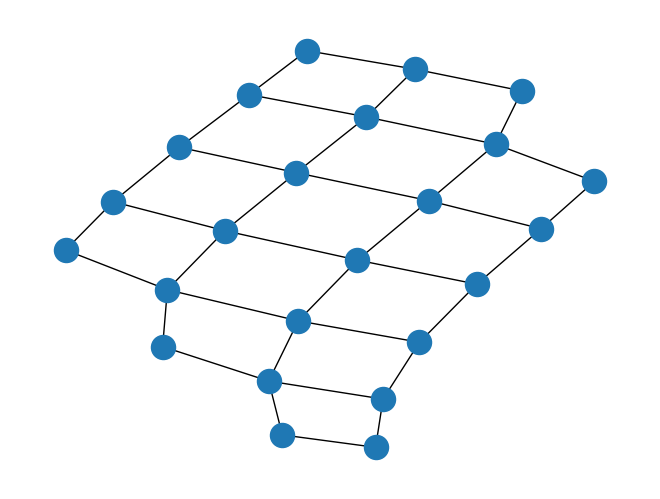

In [73]:
import matplotlib.pyplot as plt
random_table = generate_random_table(2,3,15)
graph = graph_of_table(random_table)
layout = networkx.spring_layout(graph)
networkx.draw(graph,pos=layout)
plt.show()

### 2.4 Expérimentation du test exact de Fisher vers le test approximative du $\chi^2$.

TO BE CONTINUED